In [1]:
import os
import numpy as np
import pandas as pd
import nibabel as nib
import nilearn
from nilearn import image, plotting, connectome, datasets, maskers
from nilearn.input_data import NiftiMasker, NiftiMapsMasker, NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure
from nilearn.masking import compute_brain_mask
from nilearn.plotting import plot_roi, show

from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

### Experimental setup
- 51 subjects with mild depression and 21 healthy subjects
- 100 scans per session with 2.5 s retention time (TR) between scans and composed of 25 slices



In [13]:
# Get the directory of the current notebook
notebook_dir = os.path.dirname(os.path.abspath("__file__"))

# Move up one directory from 'notebooks' to the project root
project_root = os.path.abspath(os.path.join(notebook_dir, '..'))

# Build the path to the data folder
data_path = os.path.join(project_root, 'data')

print(f"Project Root: {project_root}")
print(f"Data Path: {data_path}")

Project Root: c:\Users\stefa\Desktop\Bootcamp\fMRI-Classification
Data Path: c:\Users\stefa\Desktop\Bootcamp\fMRI-Classification\data


In [14]:
# Load an example fMRI scan (Replace with actual file)
fmri_file = os.path.join(data_path, "sub-02/func/sub-02_task-rest_bold.nii.gz")
fmri_img = nib.load(fmri_file)

In [ ]:
# Check alignment
# Plot anatomical T1 weigthed and functional MRI scans and compare

# Load T1-weighted structural MRI
t1_img = nib.load(os.path.join(data_path, "sub-01/anat/sub-01_T1w.nii.gz"))
print("Loaded T1-weighted MRI Shape:", t1_img.shape)

# Load fMRI scan
fmri_img = nib.load(os.path.join(data_path, "sub-02/func/sub-02_task-rest_bold.nii.gz"))
print("Loaded fMRI Shape:", fmri_img.shape)

# Plot the anatomical T1w scan
plotting.plot_anat(t1_img, title="T1-weighted MRI")

# Plot the first time point of the fMRI scan
plotting.plot_epi(fmri_img.slicer[:, :, :, 0], title="Raw fMRI (First Time Point)")

# Create an interactive display
display = plotting.plot_anat(t1_img, title="T1w MRI with fMRI Overlay")
# Overlay fMRI on T1-weighted MRI
mean_fmri_img = image.mean_img(fmri_img)

# Add the fMRI overlay with transparency (alpha)
display.add_overlay(mean_fmri_img, alpha=0.5)  # Adjust alpha for better visibility


In [ ]:
#Test co-registration
registered_fmri_img = image.resample_to_img(fmri_img, t1_img, interpolation='linear')
# Plot the co-registered fMRI mean image
registered_mean_fmri_img = image.mean_img(registered_fmri_img)
plotting.plot_epi(registered_mean_fmri_img, title="Co-registered fMRI Overlay on T1w")

In [ ]:
# Load the standard MNI152 template (2mm resolution) and resample
mni_template = datasets.load_mni152_template(resolution=2)

fmri_mni = image.resample_img(
                registered_fmri_img, target_affine=mni_template.affine, target_shape=mni_template.shape, 
                interpolation="continuous", force_resample=True, copy_header=True
            )
fmri_mni

C:\Users\stefa\AppData\Local\Temp\ipykernel_25236\3433460272.py:4: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  registered_fmri_img = image.resample_to_img(fmri_img, t1_img, interpolation='linear')
c:\Users\stefa\Desktop\Bootcamp\fMRI-Classification\.venv\Lib\site-packages\nilearn\image\resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


In [ ]:
# Smooth image
smoothed_fmri_img = image.smooth_img(fmri_mni, fwhm=6)


In [34]:
# Apply Schaefer 200 Atlas to Extract ROI-based Time-Series
atlas = datasets.fetch_atlas_schaefer_2018(n_rois=200, yeo_networks=7, resolution_mm=2)

# Exclude the first label (background)

labels_masker = NiftiLabelsMasker(labels_img=atlas.maps, standardize=False, memory='nilearn_cache', n_jobs=-1)
# Expected number of ROIs (excluding background label)

roi_time_series = labels_masker.fit_transform(smoothed_fmri_img)


    

[get_dataset_dir] Dataset found in C:\Users\stefa\nilearn_data\schaefer_2018


In [ ]:
# Inpect label counts and roi
print(f"Atlas Labels Count: {len(atlas.labels)}")
print(f"Extracted ROI Time-Series Shape: {roi_time_series.shape}")  # Should match atlas labels count


Atlas Labels Count: 200
Extracted ROI Time-Series Shape: (100, 200)


In [ ]:
# Compute Functional Connectivity (Pearson correlation between brain regions)
correlation_measure = connectome.ConnectivityMeasure(kind='correlation')
correlation_matrix = correlation_measure.fit_transform([roi_time_series])[0]

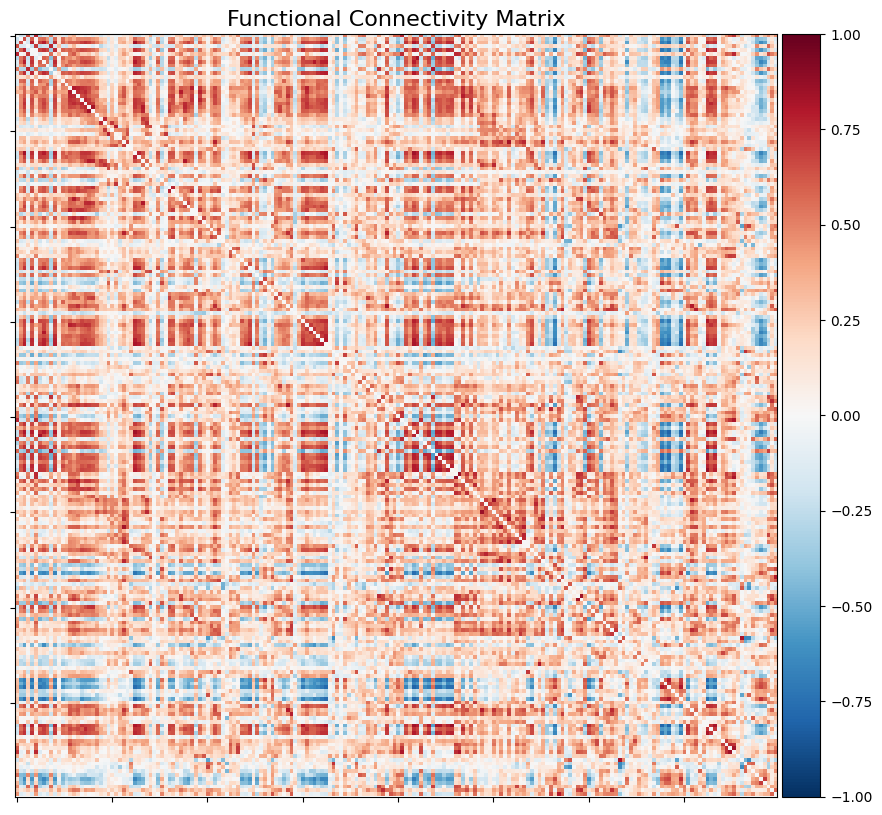

In [ ]:
# Visualize Functional Connectivity Matrix
np.fill_diagonal(correlation_matrix, 0)

plotting.plot_matrix(
    correlation_matrix, 
    figure=(10, 8), 
    title='Functional Connectivity Matrix',
    vmax=1, vmin=-1, 
    colorbar=True
)

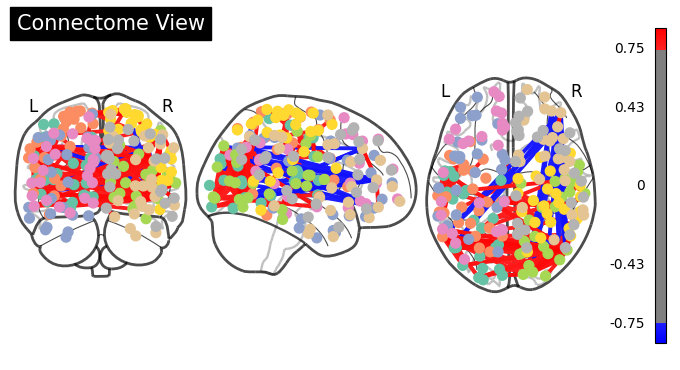

In [43]:
coords = plotting.find_parcellation_cut_coords(atlas.maps)
plotting.plot_connectome(
    correlation_matrix, coords,
    title="Connectome View",
    edge_threshold=0.75,  # Show top 10% strongest connections
    colorbar=True
)


In [44]:
plotting.view_connectome(
    correlation_matrix, 
    node_coords=coords, 
    edge_threshold=0.15  # Adjust threshold as needed
)
# view.open_in_browser()
